# Large Scale Image Denoising with Manifold Traversal

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))


from utils.utils_train import train_network_wrapper
from utils.utils_demo_growth import MT_perform_traversal, MT_denoise_local
from utils.utils_images import image_to_patches, patches_to_image_with_positions, load_images, preprocess_images, get_patches_from_images, flatten_patches

import pickle

# load data

In [2]:
save_dir = '/data/shiyu/projects/MT/MT_code/images/large_scale_image_denoising'
image_dir = '/data/shiyu/projects/MT/MT_code/images/image_data/ImageNet'
images, filenames = load_images(image_dir)
print(f"Loaded {len(images)} images")

Loaded n02102040_1329.JPEG with shape (375, 500, 3)
Loaded n02102040_3837.JPEG with shape (333, 500, 3)
Loaded n02102040_759.JPEG with shape (500, 376, 3)
Loaded n02102040_3923.JPEG with shape (400, 500, 3)
Loaded n02102040_3225.JPEG with shape (333, 500, 3)
Loaded n02102040_3496.JPEG with shape (335, 500, 3)
Loaded n02102040_4679.JPEG with shape (480, 360, 3)
Loaded n02102040_875.JPEG with shape (375, 500, 3)
Loaded n02102040_468.JPEG with shape (346, 500, 3)
Loaded n02102040_8126.JPEG with shape (377, 500, 3)
Loaded n02102040_76.JPEG with shape (333, 500, 3)
Loaded n02102040_7517.JPEG with shape (471, 500, 3)
Loaded n02102040_2326.JPEG with shape (375, 500, 3)
Loaded n02102040_4956.JPEG with shape (360, 351, 3)
Loaded n02102040_738.JPEG with shape (375, 500, 3)
Loaded n02102040_1305.JPEG with shape (480, 640, 3)
Loaded n02102040_3255.JPEG with shape (614, 493, 3)
Loaded n02102040_7406.JPEG with shape (375, 500, 3)
Loaded n02102040_1238.JPEG with shape (400, 500, 3)
Loaded n02102040_1

# Process Images

In [3]:
sigma = 0.1 #noise level


orig_img_scaled, img_scaled, noisy_images, clean_images = preprocess_images(images=images, start_idx=0, num_imgs=300, sigma=sigma)
clean_patches, noisy_patches, clean_positions, noisy_positions, N_patches_per_img = get_patches_from_images(clean_images=clean_images, noisy_images=noisy_images, patch_size=8, stride=8)
clean_patches_flattened, noisy_patches_flattened = flatten_patches(clean_patches=clean_patches, noisy_patches=noisy_patches)


#shuffle the data
permutation = np.random.permutation(len(noisy_patches_flattened))
shuffled_clean_patches = clean_patches_flattened[permutation, :]
shuffled_noisy_patches = noisy_patches_flattened[permutation, :]


# each col is a point
X_train = shuffled_noisy_patches.T
X_natural_train = shuffled_clean_patches.T
N_train = X_train.shape[1]
print(f'N_train = {N_train}')


#dimensions
D = clean_patches[0].shape[1] * clean_patches[0].shape[2] * clean_patches[0].shape[3]
d = 4

print(f'D = {D}, d = {d}')

Total number of original images: len(img_scaled_orig) = 955
Total number of RGB images: len(img_scaled) for training = 300
Number of clean images: len(clean_images) = 300
Number of noisy images: len(noisy_images) = 300
Number of total patches in noisy images: 894262
N_train = 894262
D = 192, d = 4


In [27]:
(894262 // 10000) * 10000

890000

In [28]:
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"]  # Using Times instead of Computer Modern to avoid font issues
})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3777325791990731..1.3592427681599188].


idx_r =  260
N_previous_patches =  2542
N_cur_patch =  2914
N_patches_til_now =  779542
N_patches_til_now + N_cur_patch =  782456
img_scaled[idx_r].shape =  (376, 500, 3)


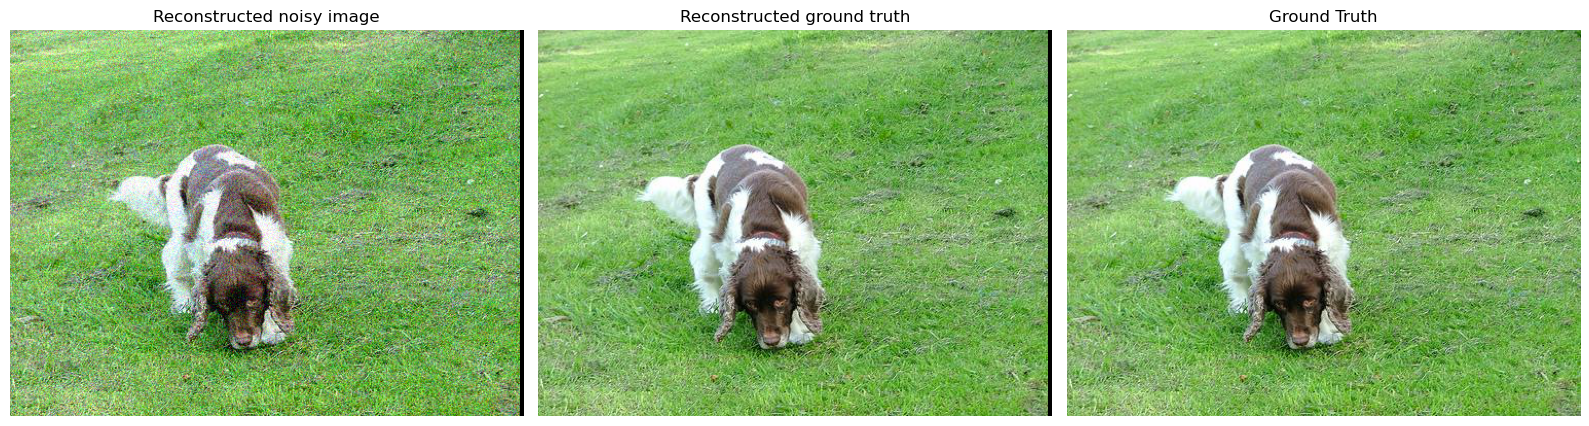

In [4]:
# Reconstruct one image to sanity check


idx_r = np.random.randint(0, len(noisy_images))
print('idx_r = ', idx_r)



print('N_previous_patches = ', N_patches_per_img[idx_r-1])
N_cur_patch = N_patches_per_img[idx_r]
print('N_cur_patch = ', N_cur_patch)


N_patches_til_now = int(np.sum(N_patches_per_img[:idx_r]))

print('N_patches_til_now = ', N_patches_til_now)
print('N_patches_til_now + N_cur_patch = ', N_patches_til_now + N_cur_patch)



print('img_scaled[idx_r].shape = ', img_scaled[idx_r].shape)
image_height = img_scaled[idx_r].shape[0]
image_width = img_scaled[idx_r].shape[1]



# convert currrent vector patches to patches
cur_list = (noisy_patches_flattened[N_patches_til_now: N_patches_til_now + N_cur_patch, :]).reshape(-1, 8, 8, 3)
cur_clean_list = (clean_patches_flattened[N_patches_til_now: N_patches_til_now + N_cur_patch, :]).reshape(-1, 8, 8, 3)



# get reconstructed images from patches
rec_noisy_img = patches_to_image_with_positions(cur_list, noisy_positions[idx_r], image_height, image_width)
rec_clean_img = patches_to_image_with_positions(cur_clean_list, clean_positions[idx_r], image_height, image_width)




plt.figure(figsize = (16, 10))
plt.subplot(131)
plt.imshow(rec_noisy_img)
plt.title('Reconstructed noisy image')
plt.axis('off')

plt.subplot(132)
plt.imshow(rec_clean_img)
plt.title('Reconstructed ground truth')
plt.axis('off')

plt.subplot(133)
plt.imshow(clean_images[idx_r])
plt.title('Ground Truth')
plt.axis('off')


plt.tight_layout()
plt.show()

# train denoisers

In [5]:

# define hyperparams
R_is_const_list = [True]

R_denoising_list = [2.5]

R_1st_order_nbrs_list = [3]

d_parallel_list = [np.sqrt(20 * sigma**2 * d)]

prod_coeff_list = [1.2]

exp_coeff_list = [1/2]

name_list = ["NETWORK"]

network_params_list = []
errors_list = []

In [6]:
R_denoising_list

[2.5]

In [7]:

for i in range(len(R_denoising_list)):
    print(f"TRAINING {name_list[i]}")
    network_params, errors = train_network_wrapper(R_is_const_list[i], R_denoising_list[i], R_1st_order_nbrs_list[i], d_parallel_list[i], prod_coeff_list[i], exp_coeff_list[i], name_list[i], 
                                                   D, d, sigma,
                                                   N_train, X_train, X_natural_train, batch_size=10000)
    network_params_list.append(network_params)
    errors_list.append(errors)
    print("~~~~~~~~~~~~\n \n \n ")



with open(os.path.join(save_dir, f'large_scale_network_params.pkl'), 'wb') as f:
    pickle.dump(network_params_list, f)



with open(os.path.join(save_dir, f'large_scale_network_errors.pkl'), 'wb') as f:
    pickle.dump(errors_list, f)

TRAINING NETWORK
TOTAL TIME =  14.220076322555542
10000 samples processed...
TOTAL TIME =  27.629814386367798
20000 samples processed...
TOTAL TIME =  38.75411033630371
30000 samples processed...
TOTAL TIME =  46.923834562301636
40000 samples processed...
TOTAL TIME =  56.65462327003479
50000 samples processed...
TOTAL TIME =  66.93684983253479
60000 samples processed...
TOTAL TIME =  76.25803565979004
70000 samples processed...
TOTAL TIME =  86.58836078643799
80000 samples processed...
TOTAL TIME =  94.80258750915527
90000 samples processed...
TOTAL TIME =  104.42562985420227
100000 samples processed...
TOTAL TIME =  111.73060154914856
110000 samples processed...
TOTAL TIME =  123.81101584434509
120000 samples processed...
TOTAL TIME =  127.04481053352356
130000 samples processed...
TOTAL TIME =  137.25529503822327
140000 samples processed...
TOTAL TIME =  145.88590669631958
150000 samples processed...
TOTAL TIME =  153.55223774909973
160000 samples processed...
TOTAL TIME =  164.5200

# training error curve

In [30]:

import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"]  # Using Times instead of Computer Modern to avoid font issues
})


NETWORK
Number of landmarks: 61731

Number of first-order edges: 1048573

Number of zero-order edges: 67166

Total Num Points Assigned to Network: 890000



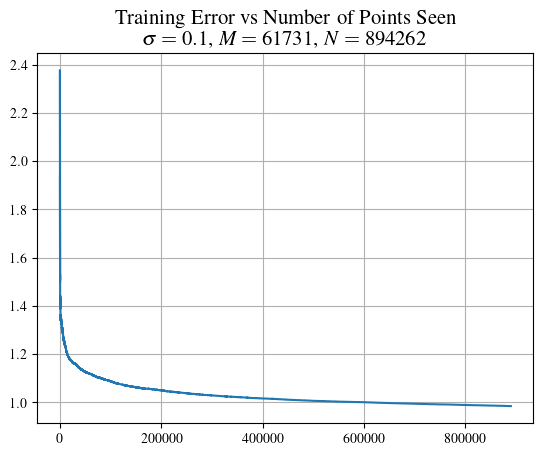

----------------------------------------------------------------------------------------------------------------------


In [31]:


for net_idx in range(len(R_denoising_list)):
    print(f'{name_list[net_idx]}')


    (mean_MT_SE, mean_data_SE, all_MT_SE) = errors_list[net_idx]
    [local_params, nbrs_info, misc] = network_params_list[net_idx]

    
    (Q, T, S_collection, P, Xi)           = local_params
    (N1, W1, N0, W0)                      = nbrs_info
    (tangent_colors,D, d, M, P)           = misc


    print(f"Number of landmarks: {M}\n")
    print(f"Number of first-order edges: {sum(len(inner_list) for inner_list in N1)}\n")
    print(f"Number of zero-order edges: {sum(len(inner_list) for inner_list in N0)}\n")
    print(f"Total Num Points Assigned to Network: {np.sum(np.array(P))}\n")


    plt.figure()
    plt.plot(mean_MT_SE, label='mean_MT_SE')
    plt.grid()
    plt.rcParams['text.usetex'] = True  # Turn off LaTeX mode
    plt.title(f'Training Error vs Number of Points Seen\n$\\sigma={sigma}$, $M={M}$, $N={N_train}$', fontsize=15)
    plt.savefig(f"large_scale_trainingcurve_{net_idx}.pdf", bbox_inches="tight")
    plt.show()

    print('----------------------------------------------------------------------------------------------------------------------')

## Test noisy image

In [22]:
num_imgs  = 1
# idx_test  = len(noisy_images) + 10
idx_test = 829
print(f'idx_test = {idx_test}')

orig_img_scaled, img_scaled, noisy_images, clean_images = preprocess_images(images=images, start_idx=idx_test, num_imgs=num_imgs, sigma=sigma)
clean_patches, noisy_patches, clean_positions, noisy_positions, N_patches_per_img = get_patches_from_images(clean_images=clean_images, noisy_images=noisy_images, patch_size=8, stride=8)
clean_patches_flattened, noisy_patches_flattened = flatten_patches(clean_patches=clean_patches, noisy_patches=noisy_patches)

if num_imgs == 1:
    idx_test = 0

# each col is a point
X_test = noisy_patches_flattened.T
X_natural_test = clean_patches_flattened.T
N_test = X_test.shape[1]
print(f'N_train = {N_test}')

idx_test = 829
Total number of original images: len(img_scaled_orig) = 955
Total number of RGB images: len(img_scaled) for training = 1
Number of clean images: len(clean_images) = 1
Number of noisy images: len(noisy_images) = 1
Number of total patches in noisy images: 2542
N_train = 2542


In [23]:
denoised_patches_list = []

for net_idx in range(len(R_denoising_list)):

    print(f'{name_list[net_idx]}')

    [local_params, nbrs_info, misc] = network_params_list[net_idx]
    
    (Q, T, S_collection, P, Xi)           = local_params
    (N1, W1, N0, W0)                      = nbrs_info
    (tangent_colors,D, d, M, P)           = misc


    denoised_patches_flattened = np.zeros(noisy_patches_flattened.shape)



    for n in range(N_test):
        x = noisy_patches_flattened[n,:]
        q_mt, _, _, _, mt_mults = MT_perform_traversal(x, Q, T, N1, W1,Xi, N0, W0, calc_mults=False)
        x_mt_hat = MT_denoise_local(x, Q, T, q_mt)
        denoised_patches_flattened[n,:] = x_mt_hat

    denoised_patches = denoised_patches_flattened.reshape(-1, 8, 8, 3)
    denoised_patches_list.append(denoised_patches)

NETWORK


# plot

In [19]:

import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"]  # Using Times instead of Computer Modern to avoid font issues
})


NETWORK


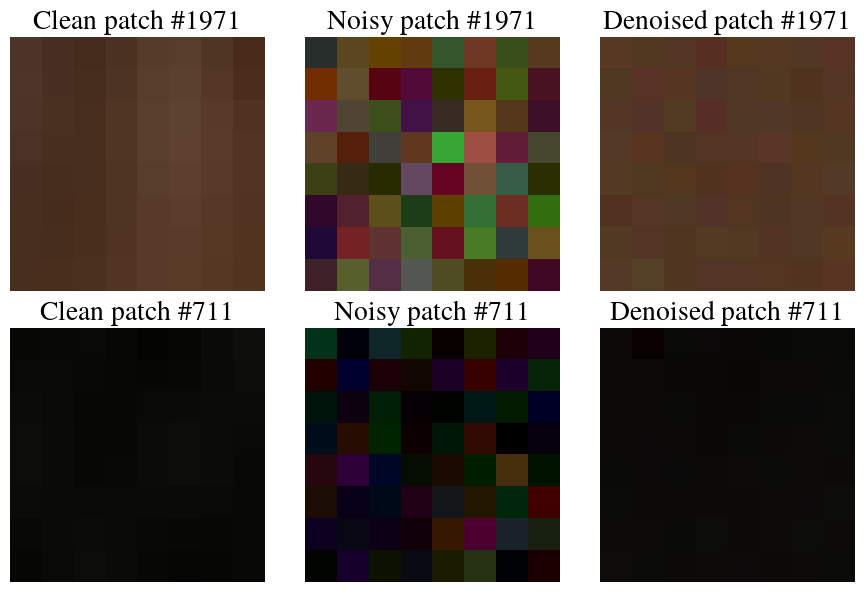

In [32]:

# idx1 = np.random.randint(0, N_test)
# idx2 = np.random.randint(0, N_test)

idx1 = 1971
idx2 = 711


for net_idx in range(len(R_denoising_list)):
    print(f'{name_list[net_idx]}')

    denoised_patches = denoised_patches_list[net_idx]

    plt.figure(figsize=(9,6))

    plt.subplot(231)
    plt.imshow(np.clip(clean_patches[idx_test][idx1],0.0,1.0))
    plt.title(r'Clean patch $\#%d$' % idx1, fontsize=20)
    plt.axis('off')

    plt.subplot(232)
    plt.imshow(np.clip(noisy_patches[idx_test][idx1],0.0,1.0))
    plt.title(r'Noisy patch $\#%d$' % idx1, fontsize=20)
    plt.axis('off')

    plt.subplot(233)
    plt.imshow(np.clip(denoised_patches[idx1],0.0,1.0))
    plt.title(r'Denoised patch $\#%d$' % idx1, fontsize=20)
    plt.axis('off')

    plt.subplot(234)
    plt.imshow(np.clip(clean_patches[idx_test][idx2],0.0,1.0))
    plt.title(r'Clean patch $\#%d$' % idx2, fontsize=20)
    plt.axis('off')

    plt.subplot(235)
    plt.imshow(np.clip(noisy_patches[idx_test][idx2],0.0,1.0))
    plt.title(r'Noisy patch $\#%d$' % idx2, fontsize=20)
    plt.axis('off')

    plt.subplot(236)
    plt.imshow(np.clip(denoised_patches[idx2],0.0,1.0))
    plt.title(r'Denoised patch $\#%d$' % idx2, fontsize=20)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"large_scale_patches_{net_idx}.pdf", bbox_inches="tight")

NETWORK
noisy-orig-sqdist - denoised-orig-sqdist is 3311.958052559342
clip-noisy-orig-sqdist - clip-denoised-orig-sqdist is 2628.8949188900024
--------------------------------------------------------------------------------------------------


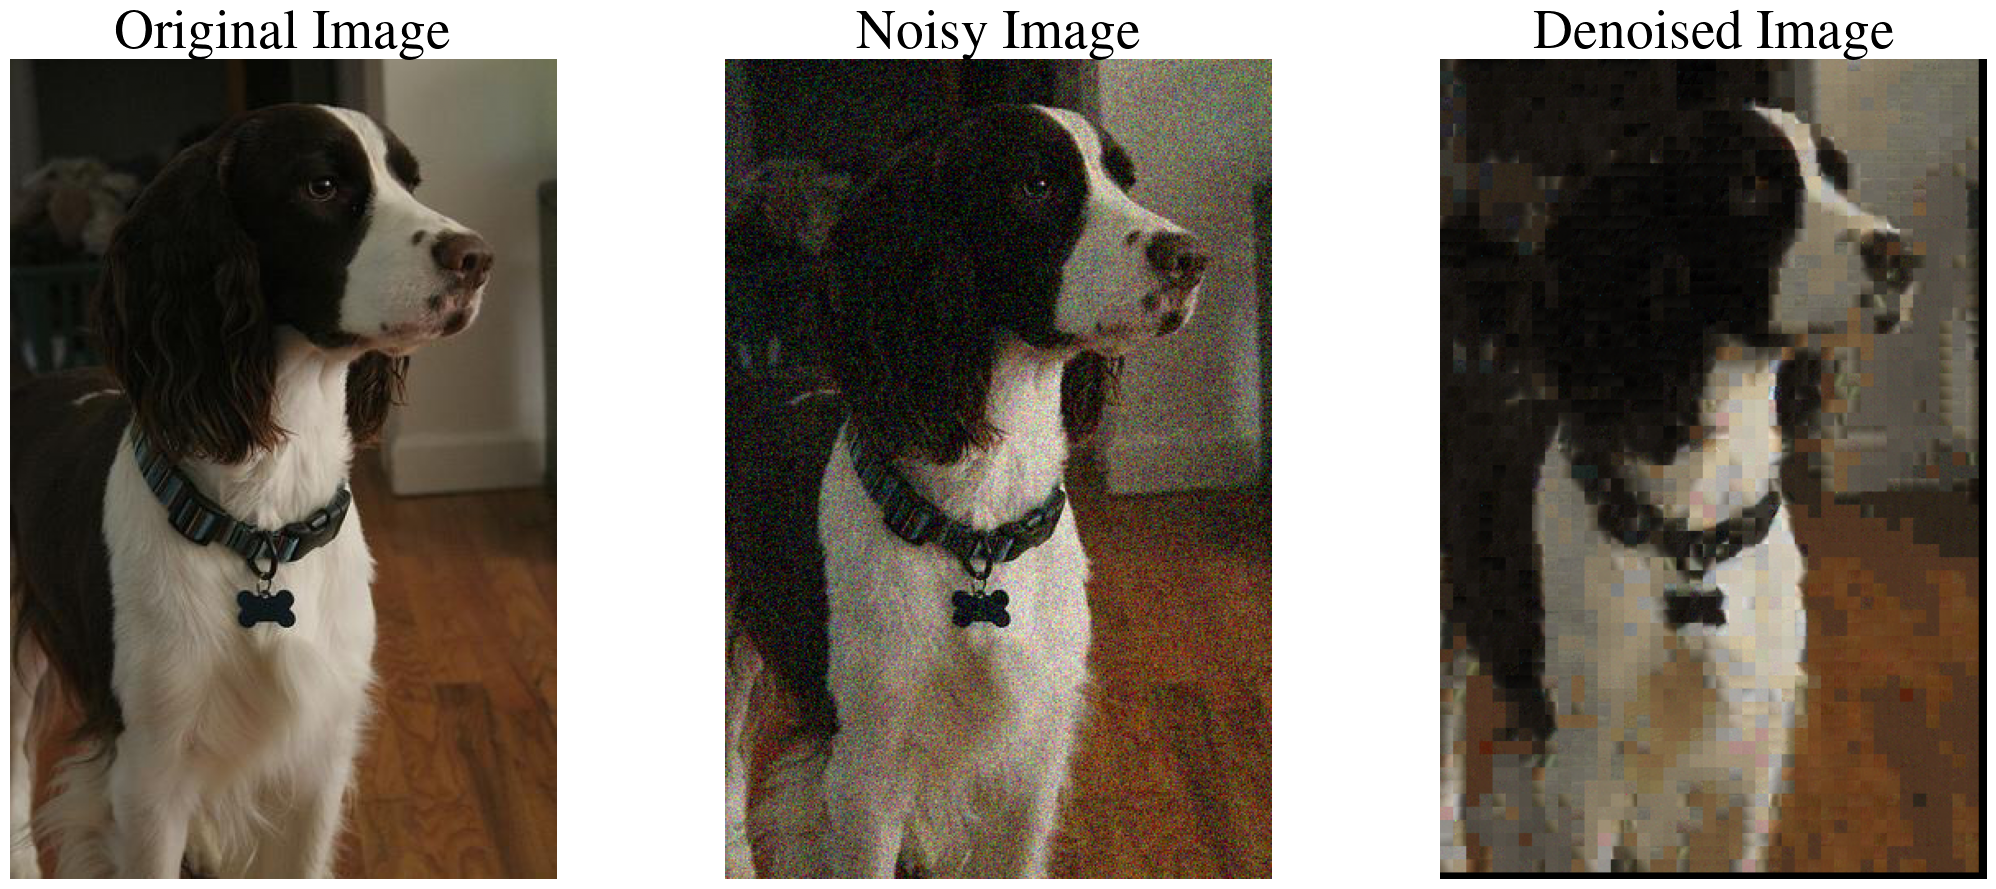

In [33]:
img_scaled_clip = np.clip(img_scaled, 0.0, 1.0)
noisy_img_clip = np.clip(noisy_images, 0.0, 1.0)





for net_idx in range(len(R_denoising_list)):

    denoised_patches = denoised_patches_list[net_idx]
    denoised_image = patches_to_image_with_positions(denoised_patches, noisy_positions[idx_test], img_scaled[idx_test].shape[0], img_scaled[idx_test].shape[1])

    denoised_image_clip = np.clip(denoised_image, 0.0, 1.0)

    
    noisy_orig_sqdist_denoised_orig_sqdist = np.sum((img_scaled[idx_test] - noisy_images[idx_test])**2) - np.sum((img_scaled[idx_test] - denoised_image)**2)
    clip_noisy_orig_sqdist_denoised_orig_sqdist = np.sum((img_scaled_clip[idx_test] - noisy_img_clip[idx_test])**2) - np.sum((img_scaled_clip[idx_test] - denoised_image_clip)**2)



    print(f'{name_list[net_idx]}')
    print(f'noisy-orig-sqdist - denoised-orig-sqdist is {noisy_orig_sqdist_denoised_orig_sqdist}')
    print(f'clip-noisy-orig-sqdist - clip-denoised-orig-sqdist is {clip_noisy_orig_sqdist_denoised_orig_sqdist}')
    print('--------------------------------------------------------------------------------------------------')

    plt.figure(figsize=(22, 9))

    plt.subplot(1, 3, 1)
    plt.imshow(img_scaled_clip[idx_test])
    plt.title(r'{Original Image}', fontsize=40) 
    plt.savefig(f"large_scale_orig_img_{net_idx}.pdf", bbox_inches="tight")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(noisy_img_clip[idx_test])
    plt.title(r'{Noisy Image}', fontsize=40) 
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(denoised_image_clip)
    plt.title(r'{Denoised Image}', fontsize=40)  
    plt.savefig(f"large_scale_denoised_img_{net_idx}.pdf", bbox_inches="tight")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"large_scale_images_{net_idx}.pdf", bbox_inches="tight")
    plt.show()